In [1]:
import os 
import sys 
import random
import time

import numpy as np 
import pandas as pd
from typing import Any, Tuple 
import nltk
nltk.download('punkt')


import einops 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn import preprocessing 

random.seed(16)

import tensorflow as tf 
import tensorflow_text  as tf_text 

from Bio import pairwise2
from functools import partial
from collections import deque
import pathlib


use_builtins = True

import pickle as pkl 

/student/mrahbar/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package punkt to /student/mrahbar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2022-12-11 17:05:33.877864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 17:05:34.048925: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the enviro

In [2]:

##########################################################################################
# tf.config.experimental.set_memory_growth(physical_devices[0], True)


physical_devices = tf.config.list_physical_devices('GPU')
try:
    # Disable first GPU
    GPUs = tf.config.set_visible_devices(physical_devices[0], 'GPU')
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
    logical_devices = tf.config.list_logical_devices('GPU')

except:
    # Invalid device or cannot modify virtual devices once initialized.
    print("Invalid device or cannot modify virtual devices once initialized.")
    pass

##########################################################################################

2022-12-11 17:05:41.395567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 17:05:42.223577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 35419 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:1c:00.0, compute capability: 8.0


In [3]:
with open('train.tsv', 'r') as f: 
    data = f.read().strip('\n').split('\n')
    
with open('test-03.tsv', 'r') as f: 
    test_data = f.read().strip('\n').split('\n')

In [4]:
test_data[0]

'Oradye\tO-r-a-d-y-e'

In [5]:
for i in range(len(data)): 
    data[i] = data[i].split('\t')
    data[i][0] = list(data[i][0].lower())
    data[i][1] = data[i][1].strip('\n').lower().split('-')
    
for i in range(len(test_data)): 
    test_data[i] = test_data[i].split('\t')
    test_data[i][0] = list(test_data[i][0].lower())
    test_data[i][1] = test_data[i][1].strip('\n').lower().split('-')

In [6]:
data[0]

[['k', 'o', 'n', 's', 'i', 'l', 't', 'a', 'n'],
 ['k', 'on', 's', 'i', 'l', 't', 'an']]

In [7]:
test_data[0]

[['o', 'r', 'a', 'd', 'y', 'e'], ['o', 'r', 'a', 'd', 'y', 'e']]

In [8]:
label_pool = [] 
char_pool = [] 
for i in range(len(data)):
    label_pool += data[i][1]
    char_pool += data[i][0]
    
label_pool = list(set(label_pool))
char_pool = list(set(char_pool))

In [9]:
set(label_pool).difference(set(char_pool))

{'an', 'ch', 'en', 'ng', 'on', 'ou', 'oun', 'ui'}

In [10]:
def load_data(data):
    context = [] 
    target = [] 
    for i in range(len(data)-1):
        temp_context = [] 
        temp_target = [] 
        temp_context.append(data[i][0])
        temp_target.append(data[i][1])
        context += temp_context
        target += temp_target

    for i in range(len(context)):
        context[i] = " ".join(context[i])
        target[i] = " ".join(target[i])

    return target, context

In [11]:
target_raw, context_raw = load_data(data)

In [12]:
target_raw_test, context_raw_test = load_data(test_data)

In [13]:
print(context_raw[-1])
print(target_raw[-1])

m a n z è
m an z è


## References: 
### Using an attention-based sequence to sequence encoder decoder
1. https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [14]:
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

In [15]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 32

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

context_raw_train = []
target_raw_train = []  
context_raw_val = []
target_raw_val = []
for i in range(len(is_train)):
    if is_train[i]: 
        context_raw_train.append(context_raw[i])
        target_raw_train.append(target_raw[i])
    else:
        context_raw_val.append(context_raw[i])
        target_raw_val.append(target_raw[i])
        

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw_train, target_raw_train))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw_val, target_raw_val))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [16]:
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

tf.Tensor(
[b'k o n p e t a n' b'r e l y a s y o n' b'k o m i n a l'
 b'a g r i k i l t \xc3\xa8' b'a n n w i'], shape=(5,), dtype=string)

tf.Tensor(
[b'k on p e t an' b'r e l y a s y on' b'k o m i n a l'
 b'a g r i k i l t \xc3\xa8' b'an n w i'], shape=(5,), dtype=string)


In [17]:
example_text = tf.constant('m a n z è')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'm a n z \xc3\xa8'
b'm a n z e\xcc\x80'


In [18]:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [19]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

m a n z è
[START] m a n z è [END]


In [20]:
max_vocab_size = 10000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [21]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'a', 'n', 'e', 'i', 'o', 's']

In [22]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'a', 'i', 'e', 's', 't', 'l']

In [23]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 12, 8, 5, 17, 6, 10, 4, 5, 3], [2, 13, 6, 11, 14, 4, 9, 14, 8, 5, 3],
 [2, 12, 8, 15, 7, 5, 4, 11, 3]]>

In [24]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] k o n p e t a n [END]'

In [25]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [26]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy()) 

[ 2 17 16 17  3  0  0  0  0  0]

[ 2 17 16 17  0  0  0  0  0  0]
[17 16 17  3  0  0  0  0  0  0]


In [30]:
UNITS = 128

In [31]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                                   mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                # Return the sequence and state
                                return_sequences=True,
                                recurrent_initializer='glorot_uniform'))

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [32]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

2022-12-11 17:06:06.900695: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


Context tokens, shape (batch, s): (32, 13)
Encoder output, shape (batch, s, units): (32, 13, 128)


In [33]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = ShapeChecker()

        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)
    
        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [34]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (32, 13, 128)
Target sequence, shape (batch, t, units): (32, 11, 128)
Attention result, shape (batch, t, units): (32, 11, 128)
Attention weights, shape (batch, t, s):    (32, 11, 13)


2022-12-11 17:06:08.516017: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [35]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ], dtype=float32)

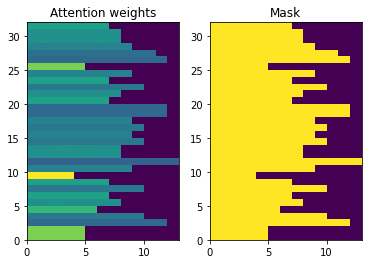

In [36]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [37]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

    
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits

In [38]:
decoder = Decoder(target_text_processor, UNITS)

In [39]:
logits = decoder(ex_context, ex_tar_in)
print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (32, 13, 128)
input target tokens shape: (batch, t) (32, 11)
logits shape shape: (batch, target_vocabulary_size) (32, 11, 36)


In [40]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [41]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

In [42]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [43]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'o i k a n n y n o\xcc\x80 o\xcc\x80',
       b't b f ou y ng b [UNK] t n', b'[UNK]         '], dtype=object)

In [44]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
                context_text_processor,
                target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        #TODO(b/250038731): remove this
        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits
    
    #@title
    # @Translator.add_method
    def translate(self,
                  texts, *,
                  max_length=50,
                  temperature=0.0):
        # Process the input texts
        context = self.encoder.convert_input(texts)
        batch_size = tf.shape(texts)[0]

        # Setup the loop inputs
        tokens = []
        attention_weights = []
        next_token, done, state = self.decoder.get_initial_state(context)

        for _ in range(max_length):
            # Generate the next token
            next_token, done, state = self.decoder.get_next_token(
                context, next_token, done,  state, temperature)

            # Collect the generated tokens
            tokens.append(next_token)
            attention_weights.append(self.decoder.last_attention_weights)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        # Stack the lists of tokens and attention weights.
        tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
        self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

        result = self.decoder.tokens_to_text(tokens)
        return result
    
    # @Translator.add_method
    def plot_attention(self, text, **kwargs):
        assert isinstance(text, str)
        output = self.translate([text], **kwargs)
        output = output[0].numpy().decode()

        attention = self.last_attention_weights[0]

        context = tf_lower_and_split_punct(text)
        context = context.numpy().decode().split()

        output = tf_lower_and_split_punct(output)
        output = output.numpy().decode().split()[1:]

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)

        ax.matshow(attention, cmap='viridis', vmin=0.0)

        fontdict = {'fontsize': 14}

        ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
        ax.set_yticklabels([''] + output, fontdict=fontdict)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        ax.set_xlabel('Input text')
        ax.set_ylabel('Output text')

In [45]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))



In [46]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [47]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [48]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [49]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 3.583519, 'expected_acc': 0.027777777777777776}

In [50]:
val_ds

<ParallelMapDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [51]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 6s 9ms/step - loss: 3.6307 - masked_acc: 0.0871 - masked_loss: 3.6307


{'loss': 3.6307194232940674,
 'masked_acc': 0.08705911785364151,
 'masked_loss': 3.6307194232940674}

In [53]:
history = model.fit(
    train_ds.repeat(), 
    epochs=15,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/15
100/100 [==============================] - 2s 23ms/step - loss: 0.0036 - masked_acc: 0.9989 - masked_loss: 0.0036 - val_loss: 0.0040 - val_masked_acc: 0.9991 - val_masked_loss: 0.0040
Epoch 2/15
100/100 [==============================] - 2s 23ms/step - loss: 0.0044 - masked_acc: 0.9990 - masked_loss: 0.0044 - val_loss: 0.0032 - val_masked_acc: 0.9991 - val_masked_loss: 0.0032
Epoch 3/15
100/100 [==============================] - 2s 23ms/step - loss: 0.0091 - masked_acc: 0.9974 - masked_loss: 0.0091 - val_loss: 0.0228 - val_masked_acc: 0.9931 - val_masked_loss: 0.0228
Epoch 4/15
100/100 [==============================] - 2s 23ms/step - loss: 0.0172 - masked_acc: 0.9953 - masked_loss: 0.0171 - val_loss: 0.0038 - val_masked_acc: 0.9998 - val_masked_loss: 0.0038
Epoch 5/15
100/100 [==============================] - 2s 23ms/step - loss: 0.0065 - masked_acc: 0.9978 - masked_loss: 0.0065 - val_loss: 0.0094 - val_masked_acc: 0.9978 - val_masked_loss: 0.0094


In [54]:
# test_source, test_target = load_data(tagged_list_test)

In [55]:
# result = [] 
# total = 0
# for i in range(len(test_source)):
#     result.append(model.translate([test_source[i]])[0].numpy().decode())
#     total += nltk.translate.bleu_score.sentence_bleu([test_target[i]], result[-1], weights=[1])
# print(total/len(test_source))
    

In [56]:
result = [] 
total = 0
for i in range(len(context_raw_test)):
    result.append(model.translate([context_raw_test[i]])[0].numpy().decode())
    total += nltk.translate.bleu_score.sentence_bleu([target_raw_test[i]], result[-1], weights=[1])
print(total/len(context_raw_test))
    

0.8663798324165712


/tmp/ipykernel_1683575/1581141986.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmp/ipykernel_1683575/1581141986.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


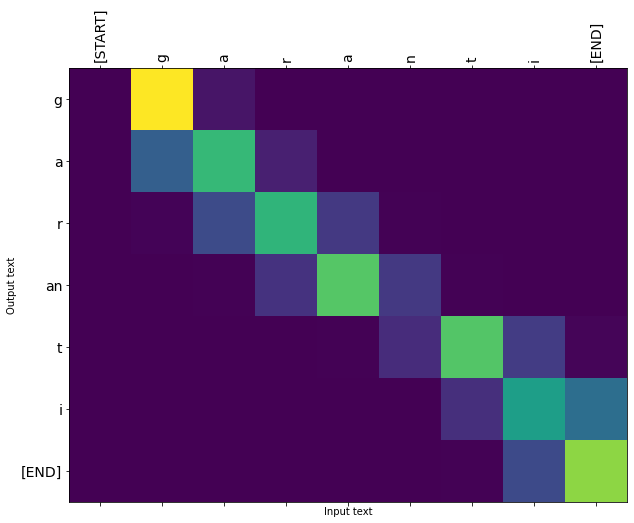

In [57]:
model.plot_attention(context_raw_test[5])

In [ ]:
len(context_raw)

In [ ]:
target_raw[8]

In [69]:
a = np.random.rand(5,5
                  )

In [70]:
a

array([[0.80766968, 0.63784749, 0.60185118, 0.66893043, 0.05094966],
       [0.59549126, 0.31727225, 0.60620483, 0.83358354, 0.60161254],
       [0.08824358, 0.47338468, 0.39200964, 0.74021602, 0.73632838],
       [0.69672165, 0.68286793, 0.81830048, 0.82367073, 0.81766322],
       [0.38340297, 0.571244  , 0.58762144, 0.70041474, 0.95205604]])

Text(0, 0.5, 'Output text')

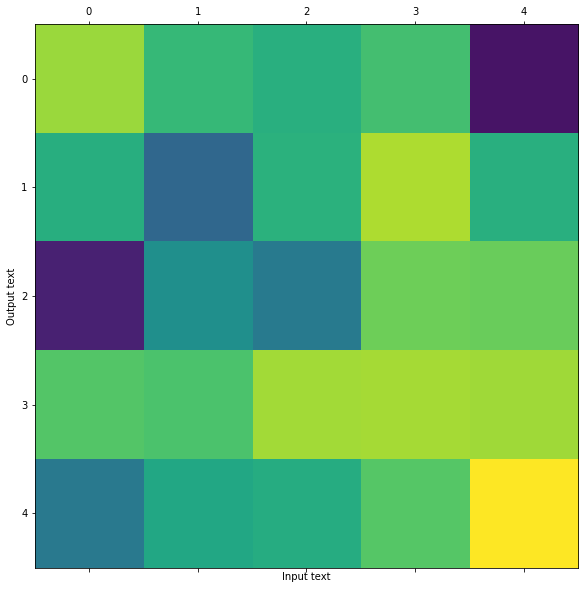

In [71]:


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

ax.matshow(a, cmap='viridis', vmin=0.0)

fontdict = {'fontsize': 14}

# ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
# ax.set_yticklabels([''] + output, fontdict=fontdict)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel('Input text')
ax.set_ylabel('Output text')

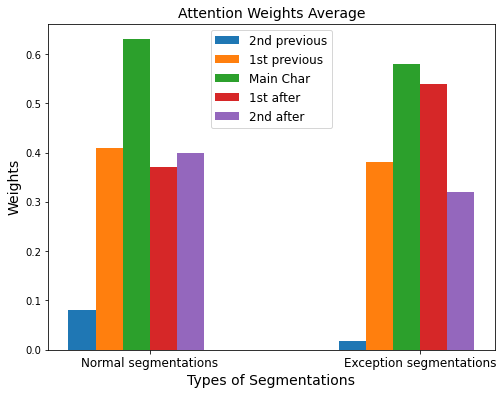

In [135]:
import numpy as np
import matplotlib.pyplot as plt
  
N = 2
ind = np.arange(N) 
width = 0.1

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
  
xvals = [0.08,0.017]
bar1 = plt.bar(ind, xvals, width) #, color = 'r'
  
yvals = [0.41, 0.38]
bar2 = plt.bar(ind+width, yvals, width) # , color='g'
  
zvals = [0.63, 0.58]
bar3 = plt.bar(ind+width*2, zvals, width) # , color = 'b'

kvals = [0.37, 0.54]
bar4 = plt.bar(ind+width*3, kvals, width) # , color = 'pink'

zzvals = [0.4, 0.32]
bar5 = plt.bar(ind+width*4, zzvals, width) # , color = 'y'
  
plt.xlabel("Types of Segmentations", fontsize=14)
plt.ylabel('Weights', fontsize=14)
plt.title("Attention Weights Average", fontsize=14)
plt.xticks([0.25,1.25], ['Normal segmentations', 'Exception segmentations'], fontsize=12)

  
# plt.xticks(ind+width,['2021Feb01', '2021Feb02', '2021Feb03'])
plt.legend( (bar1, bar2, bar3, bar4, bar5), ('2nd previous', '1st previous', 'Main Char', '1st after', '2nd after'),
          loc='upper center', fontsize=12)
plt.show()